# Model Training & Testing
This notebook is intended to help train and test various models, and expanded from our data_model_prep notebook.

In [79]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import plotly.express as px
from graphviz import Source
from IPython.display import SVG

import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

from fastai.tabular.all import *
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler

from tqdm.notebook import tqdm

from dtreeviz.trees import dtreeviz

import os
import pickle

random_state = 42
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Set up paths

In [2]:
# For python pipeline that will be run from root folder of project
# ROOT_DIR = os.path.abspath(os.curdir)

# # Pickle save paths
# training_df_path = os.path.join(ROOT_DIR,"data/processed/training_df.pkl")
# testing_df_path = os.path.join(ROOT_DIR,"data/processed/testing_df.pkl")

# Relative path for notebook
training_df_path = "../data/processed/training_df.pkl"
testing_df_path = "../data/processed/testing_df.pkl"

# likedislike processed only
# training_df_path = "../data/processed/likedislike_withcomments_processed.pkl"

# Small df for testing with comments
# training_df_path = "../data/processed/training_df_small_withcomments.pkl"

# Small df for testing
training_df_small_path = "../data/processed/training_df_small.pkl"
# Big df for testing
randompct10_pklpath=r"/run/user/1000/gvfs/smb-share:server=metebox,share=data/JAMES/datasets/youtube-meta/youtube-02-2019-dump/randompct_df_10.pkl"

## Load training and test dataframes

In [3]:
training_df = pd.read_pickle(training_df_path)
testing_df = pd.read_pickle(testing_df_path)

# big df
# training_df_big = pd.read_pickle(randompct10_pklpath)

# small df
# training_df = pd.read_pickle(training_df_small_path)

In [4]:
# Concat training df and training_df_big for testing if more data helps
# training_df = pd.concat([training_df,training_df_big])
# training_df = training_df.sample(frac=1).reset_index(drop=True)

In [5]:
# Convert bool to binary 0,1 to test performance
# training_df["NoCommentsBinary"] = training_df["NoComments"].apply(lambda x: 1 if x==True else 0)
# testing_df["NoCommentsBinary"] = testing_df["NoComments"].apply(lambda x: 1 if x==True else 0)

## Columns for model training

In [6]:
# Based on what we can get at inference time from the Youtube API or scraping
X_cols = [
    "duration",
    "age_limit",
    "view_count",
    "like_count",
#     "view_like_ratio",
    "view_like_ratio_smoothed",
    "is_comments_enabled",
    "is_live_content",
    "cat_codes",
    "desc_neu",
    "desc_neg",
    "desc_pos",
    "desc_compound",
    "comment_neu",
    "comment_neg",
    "comment_pos",
    "comment_compound",
    "votes",
#     "NoComments",
    "NoCommentsBinary"
]

y_col = "ld_score_ohe"

# Get all related columns - useful for fastai models
all_related_cols = X_cols.copy()
all_related_cols.append(y_col)

In [7]:
# Testing scaled versions
scaler = StandardScaler()
training_df_scaled_X = scaler.fit_transform(training_df[X_cols])
testing_df_scaled_X = scaler.transform(testing_df[X_cols])

## Helper Functions

In [80]:
def create_training_test_sets(df,X_cols,y_col,random_state=None):
    """
    Takes in a processed dataframe and splits it into appropriate training and test splits.
    """
    X = df[X_cols]
    y = df[y_col]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=random_state)
    print("Splits created")
    return X, y, X_train, X_test, y_train,y_test

def train_model(clf_object,model_name,X_train,y_train,X_test,y_test):
    clf_object.fit(X_train,y_train)
    acc, f1 = test_model_metrics(clf=clf_object,model_name=model_name)
    return clf_object, acc, f1

def test_model_metrics(clf, model_name,X_test,y_test):
    testpreds = clf.predict(X_test)
    acc = accuracy_score(y_test,testpreds)
    f1_scores_dict = {}
    if len(y_test.unique()) > 2:
        f1_scores_dict["f1_weighted"] = f1_score(y_test,testpreds,average="weighted")
    else:
        f1_scores_dict["f1_binary"] = f1_score(y_test,testpreds,average="binary")
        
    f1_scores_dict["f1_macro"] = f1_score(y_test,testpreds,average="macro")
    f1_scores_dict["f1_micro"] = f1_score(y_test,testpreds,average="micro")
    
    mcc = matthews_corrcoef(y_test,testpreds)

    print(f"{model_name} metrics:")
    print(f"Accuracy Score: {acc}")
    print(f"F1 scores: {f1_scores_dict}")
    print(f"MCC: {mcc}")
    return acc,f1_scores_dict,mcc

def cross_val_model(df,clf_object,X_cols,y_col,random_state,scoring,cv=5):
    """
    Takes in a df, processes it, and then outputs a cross-validation f1 score.
    Adapted from sklearn docs.
    Scoring types available here: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    """
    X, y, X_train,X_test,y_train,y_test = create_training_test_sets(df,X_cols,y_col,random_state=random_state)
    scores = cross_val_score(clf_object, X, y, cv=cv,scoring=scoring,verbose=1,n_jobs=-1)
    print(f"{scores.mean():0.2f} {scoring} with a standard deviation of {scores.std():0.2f}")
    return scores

def confusion_matrix_model(df,clf_object,X_cols,y_col,random_state,model_name):
    """
    Takes in a df, processes it, and then outputs a confusion matrix.
    Adapted from sklearn docs: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    Scoring types available here: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    """
    X, y, X_train,X_test,y_train,y_test = create_training_test_sets(df,X_cols,y_col,random_state=random_state)
    clf_object.fit(X_train,y_train)
    
    # Adapted from sklearn docs
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    titles_options = [
        (f"{model_name} Confusion matrix, without normalization", None),
        (f"{model_name} Normalized confusion matrix", "true"),
    ]
    
    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_estimator(
            clf_object,
            X_test,
            y_test,
            cmap=plt.cm.Blues,
            normalize=normalize,
        )
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

In [9]:
training_df.head(2)

,id,fetch_date,uploader,upload_date,title,desc_text,category,duration,age_limit,view_count,...,desc_pos,desc_compound,video_id,votes,comment_neg,comment_neu,comment_pos,comment_compound,NoComments,NoCommentsBinary
0,YAddSH-Vwxw,2019-02-03 03:33:17,iPhoenix,2018-08-16,Cassee & Erik - Hurts Like Hell,this video is in memory of erik may he rest in peace i am not very good at words a big reason i like making videos and why i had to make this videoi may not have known them personally but cassee and erik had this realness about them that i really loved to watch your love and faith in people bring me a happiness i cant explain from watching your videos i do not own the music or video displayed only the editing no copyright intended i do not make any profit from this video cassee joseph channel httpswwwyoutubecomchannelucthwsorry about the glitched border guysthis is a video in memory of er...,Film & Animation,230,0,9146,...,0.19,0.98,YAddSH-Vwxw,114.00,0.04,0.64,0.32,0.66,False,0
1,dfckP4lPJLA,2019-02-03 15:47:59,Gary McGoff,2016-09-15,ABSOLUTE Pre Trib RAPTURE Proof From SCRIPTURE,on the days when post tribbers try to drag you down be encouraged with these words,Education,732,0,165,...,0.14,0.15,0,0.00,0.00,0.00,0.00,0.00,True,1


## Model Training

### Dummy Classifier

Dummy Classifier metrics:
Accuracy Score: 0.5735735735735735
F1 score: 0.5760165674386105
Dummy Classifier
[[0.23821742 0.04496962 0.71681296]
 [0.23364875 0.04330872 0.72304253]
 [0.23576905 0.04405718 0.72017377]]


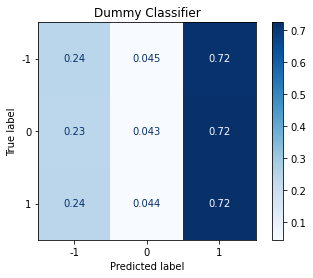

In [10]:
# Training model
dummy_clf = DummyClassifier(strategy='stratified',random_state=random_state)
dummy_clf.fit(training_df[X_cols],training_df[y_col])

# Testing model
dummy_acc,dummy_f1,dummy_mcc = test_model_metrics(dummy_clf,"Dummy Classifier",testing_df[X_cols],testing_df[y_col])

disp = ConfusionMatrixDisplay.from_estimator(
    dummy_clf,
    testing_df[X_cols],
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("Dummy Classifier")

print("Dummy Classifier")
print(disp.confusion_matrix)

### Logistic Regression

Logistic Regression Classifier metrics:
Accuracy Score: 0.6916793336546423
F1 score: 0.6744476255566724
Logistic Regression Classifier
[[6.38217421e-01 2.70087779e-04 3.61512492e-01]
 [4.82894874e-01 6.96682957e-03 5.10138297e-01]
 [1.87849388e-01 1.21273538e-03 8.10937876e-01]]


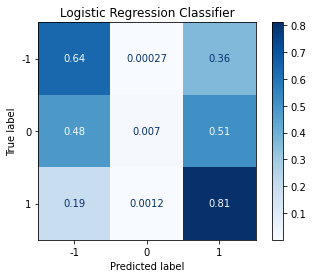

In [640]:
# Training model
logistic_clf = LogisticRegression(n_jobs=-1,random_state=random_state)
logistic_clf.fit(training_df[X_cols],training_df[y_col])

# Testing model
logistic_acc,logistic_f1,logistic_mcc = test_model_metrics(logistic_clf,"Logistic Regression Classifier",testing_df[X_cols],testing_df[y_col])

disp = ConfusionMatrixDisplay.from_estimator(
    logistic_clf,
    testing_df[X_cols],
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("Logistic Regression Classifier")

print("Logistic Regression Classifier")
print(disp.confusion_matrix)

### Random Forest

Random Forest metrics:
Accuracy Score: 0.8391663268206478
F1 score: 0.8128833066875639
RF Confusion Matrix
[[0.84163853 0.03839748 0.11996399]
 [0.28366434 0.15129458 0.56504107]
 [0.0462833  0.00510844 0.94860826]]


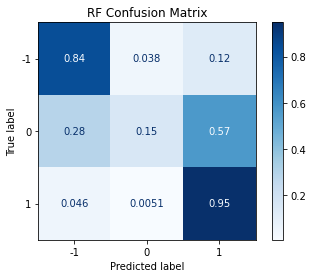

In [642]:
# Training model
rf_clf = RandomForestClassifier(n_jobs=-1,random_state=random_state)
rf_clf.fit(training_df[X_cols],training_df[y_col])

# Testing model
rf_acc,rf_f1,rf_mcc = test_model_metrics(rf_clf,"Random Forest",testing_df[X_cols],testing_df[y_col])

disp = ConfusionMatrixDisplay.from_estimator(
    rf_clf,
    testing_df[X_cols],
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("RF Confusion Matrix")

print("RF Confusion Matrix")
print(disp.confusion_matrix)

Random Forest-Scaled metrics:
Accuracy Score: 0.8390921785983514
F1 score: 0.8127953211980319
RF Confusion Matrix-Scaled
[[0.84145847 0.03835246 0.12018906]
 [0.28345638 0.15113861 0.56540501]
 [0.04629991 0.00513336 0.94856673]]


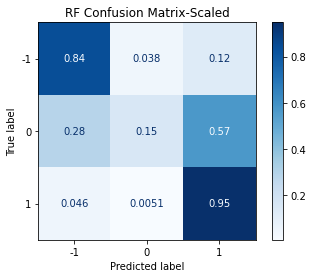

In [643]:
# Training model - scaled
rf_clf = RandomForestClassifier(n_jobs=-1,random_state=random_state)
rf_clf.fit(training_df_scaled_X,training_df[y_col])

# Testing model
rf_acc,rf_f1,rf_mcc = test_model_metrics(rf_clf,"Random Forest-Scaled",testing_df_scaled_X,testing_df[y_col])

disp = ConfusionMatrixDisplay.from_estimator(
    rf_clf,
    testing_df_scaled_X,
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("RF Confusion Matrix-Scaled")

print("RF Confusion Matrix-Scaled")
print(disp.confusion_matrix)

In [644]:
from sklearn.utils.class_weight import compute_class_weight
ohe_classes = np.array([-1,0,1])
compute_class_weight(class_weight="balanced",
                     classes=ohe_classes,
                     y=training_df[y_col])

array([1.41428031, 7.51926873, 0.46297691])

Random Forest metrics:
Accuracy Score: 0.8223223223223223
F1 scores: {'f1_weighted': 0.797295771380408, 'f1_macro': 0.5991905900408122, 'f1_micro': 0.8223223223223223}
RF Confusion Matrix
[[0.86765699 0.02538825 0.10695476]
 [0.36513466 0.11802017 0.51684517]
 [0.05814485 0.01537516 0.92647999]]


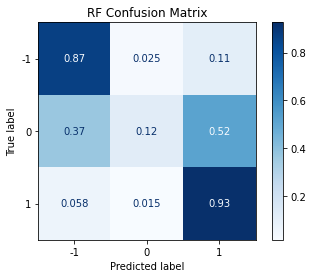

In [72]:
class_weight_dict = {-1:0.1,0:1,1:2}

# Training model
rf_clf = RandomForestClassifier(
    n_jobs=-1,
    random_state=random_state,
    class_weight = class_weight_dict,
#     max_depth=64,
# The below are good without class weights
#     min_samples_split=0.05,
#     min_samples_leaf=0.05,
#     max_depth=4,
    )
rf_clf.fit(training_df[X_cols],training_df[y_col])

# Testing model
rf_acc,rf_f1,rf_mcc = test_model_metrics(rf_clf,"Random Forest",testing_df[X_cols],testing_df[y_col])
disp = ConfusionMatrixDisplay.from_estimator(
    rf_clf,
    testing_df[X_cols],
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("RF Confusion Matrix")

print("RF Confusion Matrix")
print(disp.confusion_matrix)

In [83]:
dot_data = tree.export_graphviz(rf_clf.estimators_[0],out_file=None,feature_names=X_cols,class_names=True)
graph = Source(dot_data)
graph.render("image",view=True)


KeyboardInterrupt



In [44]:
# Dump trained classifier to joblib.pkl file so we can load it later for inference on new data.
import joblib
joblib.dump(rf_clf, "../models/rfclf.joblib.pkl", compress=9)

['../models/rfclf.joblib.pkl']

In [45]:
# Feature importance chart
# Based on stack overflow:: https://stackoverflow.com/questions/44511636/plot-feature-importance-with-feature-names
feat_importances_df = pd.DataFrame({"Feature":X_cols,"Importance":rf_clf.feature_importances_}).sort_values(by="Importance",ascending=False)
feat_importances_df["Importance"] = feat_importances_df["Importance"].round(3)
feat_importances_df

,Feature,Importance
3,like_count,0.3420
4,view_like_ratio_smoothed,0.1360
2,view_count,0.1040
0,duration,0.0670
11,desc_compound,0.0590
8,desc_neu,0.0580
10,desc_pos,0.0490
9,desc_neg,0.0360
7,cat_codes,0.0310
15,comment_compound,0.0250


In [46]:
fig = px.bar(
    feat_importances_df, 
#     x="Importance",
#     y="Feature",
    x="Feature",
    y="Importance",
    title="Random Forest - Feature Importance",
    text="Importance",
    color="Importance")
fig.update_traces(textangle=0)
fig.show()

In [646]:
rf_preds = rf_clf.predict(testing_df[X_cols])

In [647]:
real_vs_rf_df = pd.DataFrame({"real":testing_df[y_col],"pred":rf_preds})

In [648]:
real_vs_rf_df = pd.concat([testing_df[X_cols],real_vs_rf_df],axis=1)

In [649]:
real_vs_rf_df["correct"] = real_vs_rf_df["real"] == real_vs_rf_df["pred"]

In [652]:
real_vs_rf_df[(real_vs_rf_df["real"] == -1) & (real_vs_rf_df["correct"] == False) & (real_vs_rf_df["NoCommentsBinary"] == 1)]

,duration,age_limit,view_count,like_count,view_like_ratio_smoothed,is_comments_enabled,is_live_content,cat_codes,desc_neu,desc_neg,...,desc_compound,comment_neu,comment_neg,comment_pos,comment_compound,votes,NoCommentsBinary,real,pred,correct
16,143,0,4626,10,462.60,1,0,1,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1,-1,1,False
242,138,0,1129,17,66.41,1,0,24,0.86,0.00,...,0.36,0.00,0.00,0.00,0.00,0.00,1,-1,1,False
287,84,0,638,4,159.50,1,0,10,0.79,0.02,...,0.92,0.00,0.00,0.00,0.00,0.00,1,-1,1,False
297,22,0,6411,38,168.71,1,0,10,0.71,0.00,...,0.36,0.00,0.00,0.00,0.00,0.00,1,-1,1,False
298,323,0,299,3,99.67,1,0,25,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1,-1,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161294,454,0,4626,21,220.29,1,0,20,0.81,0.19,...,-0.83,0.00,0.00,0.00,0.00,0.00,1,-1,1,False
161388,219,0,77,8,9.62,1,0,22,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1,-1,1,False
161596,911,0,66,3,22.00,1,0,22,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1,-1,1,False
161680,1206,0,1938,11,176.18,1,0,25,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1,-1,1,False


Out of the errors predicting negative videos. The majority (~2186 rows vs. 684 rows) of error rows in our test set are for videos that have 0 comment sentiment, although only 1692 of that didn't have comments originally. This might show the impact of videos without comments, but also the way we substituted 0 for that.

#### Checking the RF being trained on increasingly larger dataset sizes using samples of our training data.

In [56]:
# Get our RF Classifier object
class_weight_dict = {-1:0.1,0:1,1:2}
rf_clf = RandomForestClassifier(
    n_jobs=-1,
    random_state=random_state,
    class_weight = class_weight_dict,
    )

# Training sample fractions
training_fracs = [0.0001,0.001,0.01,0.1,1]

# Training model in a loop
def train_sample_fracs(clf,training_fracs,title,random_state,X_cols):
    """
    Trains model on increasingly larger dataset sizes to test the impact of sample size.
    Returns:
        dict - dictionary of sample frac: (acc,f1_weighted)
    """
    # Init empty dict to hold metrics
    frac_dict = {}
    
    for x in tqdm(training_fracs):
        # Get title of iteration
        title_x = f"{title} - {x} Sample Fraction"
        # Get sample of training data
        sample_data = training_df.sample(frac=x,random_state=random_state).reset_index(drop=True)
        # Fit model
        clf.fit(sample_data[X_cols],sample_data[y_col])
        # Get metrics
        acc, f1, mcc = test_model_metrics(clf,title_x,testing_df[X_cols],testing_df[y_col])
        # Add metrics to dict
        frac_dict[x] = (acc,f1["f1_macro"],f1["f1_micro"],f1["f1_weighted"],mcc,len(sample_data))
        # Check confusion matrix for each iteration
        disp = ConfusionMatrixDisplay.from_estimator(
            clf,
            testing_df[X_cols],
            testing_df[y_col],
            cmap=plt.cm.Blues,
            normalize="true",
        )
        disp.ax_.set_title(f"{title} Confusion Matrix - {x} Sample Fraction")
        print(f"{title} Confusion Matrix - {x} Sample Fraction")
        print(disp.confusion_matrix)
        plt.show()
        
    return frac_dict

  0%|          | 0/5 [00:00<?, ?it/s]

Random Forest - 0.0001 Sample Fraction metrics:
Accuracy Score: 0.8134245356467579
F1 scores: {'f1_weighted': 0.7700594655304249, 'f1_macro': 0.5261154174185521, 'f1_micro': 0.8134245356467579}
Random Forest Confusion Matrix - 0.0001 Sample Fraction
[[8.78910646e-01 4.50146298e-05 1.21044339e-01]
 [4.48840595e-01 5.19912655e-05 5.51107414e-01]
 [6.86441452e-02 6.64512539e-05 9.31289404e-01]]


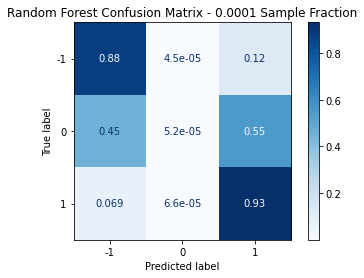

Random Forest - 0.001 Sample Fraction metrics:
Accuracy Score: 0.8068685969920538
F1 scores: {'f1_weighted': 0.7674128296578757, 'f1_macro': 0.5284172803788358, 'f1_micro': 0.8068685969920537}
Random Forest Confusion Matrix - 0.001 Sample Fraction
[[0.88152149 0.00297097 0.11550754]
 [0.43865031 0.00935843 0.55199127]
 [0.07540556 0.00408675 0.92050769]]


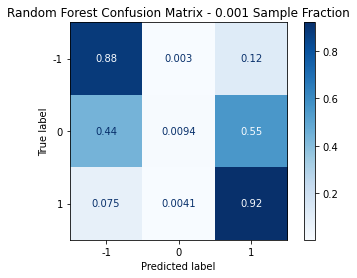

Random Forest - 0.01 Sample Fraction metrics:
Accuracy Score: 0.8171504838171505
F1 scores: {'f1_weighted': 0.7876942384061045, 'f1_macro': 0.5751518124059399, 'f1_micro': 0.8171504838171505}
Random Forest Confusion Matrix - 0.01 Sample Fraction
[[0.86599145 0.02295746 0.11105109]
 [0.39612145 0.07933867 0.52453988]
 [0.0643082  0.00967696 0.92601484]]


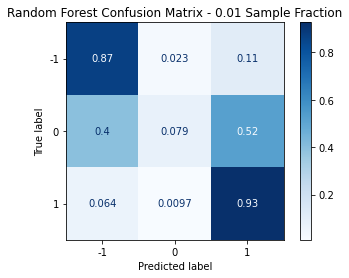

Random Forest - 0.1 Sample Fraction metrics:
Accuracy Score: 0.8192142760043994
F1 scores: {'f1_weighted': 0.7926347105762334, 'f1_macro': 0.5891390211508457, 'f1_micro': 0.8192142760043994}
Random Forest Confusion Matrix - 0.1 Sample Fraction
[[0.86203016 0.02619851 0.11177133]
 [0.37152958 0.10372257 0.52474784]
 [0.06193257 0.012443   0.92562443]]


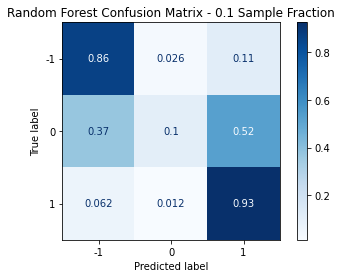

Random Forest - 1 Sample Fraction metrics:
Accuracy Score: 0.8229278661377427
F1 scores: {'f1_weighted': 0.798061434347133, 'f1_macro': 0.600338030557919, 'f1_micro': 0.8229278661377426}
Random Forest Confusion Matrix - 1 Sample Fraction
[[0.86662165 0.02606347 0.10731488]
 [0.36560258 0.11947593 0.51492149]
 [0.05662477 0.01612274 0.92725249]]


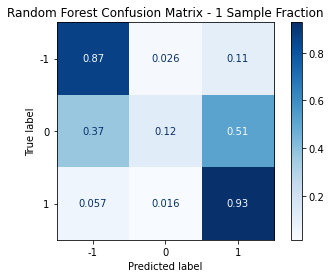

,Sample Fraction,Accuracy,F1_Macro,F1_Micro,F1 Weighted Score,MCC,Number of Rows
0,0.0001,0.8134,0.5261,0.8134,0.7701,0.5425,82.0000
1,0.0010,0.8069,0.5284,0.8069,0.7674,0.5307,815.0000
2,0.0100,0.8172,0.5752,0.8172,0.7877,0.5530,8152.0000
3,0.1000,0.8192,0.5891,0.8192,0.7926,0.5571,81519.0000
4,1.0000,0.8229,0.6003,0.8229,0.7981,0.5660,815194.0000


In [57]:
rf_frac_dict = train_sample_fracs(rf_clf,training_fracs,"Random Forest",random_state,X_cols)

# Plot metrics with sample fraction
pd.set_option('display.float_format', lambda x: '%.4f' % x)

rf_sample_metric_df = pd.DataFrame(rf_frac_dict).transpose().reset_index()
rf_sample_metric_df.columns = ["Sample Fraction","Accuracy","F1_Macro","F1_Micro","F1 Weighted Score","MCC","Number of Rows"]
display(rf_sample_metric_df)

In [59]:
sample_fig = px.line(
    rf_sample_metric_df,
    x="Sample Fraction",
    y="F1 Weighted Score",
    title="Random Forest - Performance vs. Training Sample Size",
    log_x=True)
sample_fig.update_layout(yaxis_range=[0,1])
# sample_fig.update_xaxes(tickmode= 'array',tickvals = training_fracs)
sample_fig.show()

  0%|          | 0/5 [00:00<?, ?it/s]

Random Forest - Only Like Count - 0.0001 Sample Fraction metrics:
Accuracy Score: 0.7985022059096133
F1 scores: {'f1_weighted': 0.7572246056583511, 'f1_macro': 0.5129094983320143, 'f1_micro': 0.7985022059096134}
Random Forest - Only Like Count Confusion Matrix - 0.0001 Sample Fraction
[[8.45869908e-01 0.00000000e+00 1.54130092e-01]
 [4.21129250e-01 4.15930124e-04 5.78454820e-01]
 [8.15606077e-02 1.17120335e-03 9.17268189e-01]]


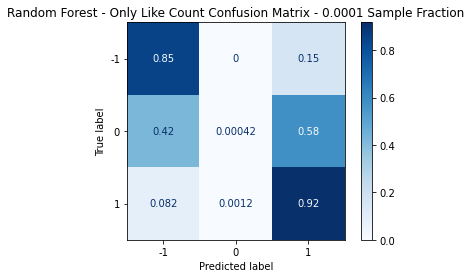

Random Forest - Only Like Count - 0.001 Sample Fraction metrics:
Accuracy Score: 0.844739801529925
F1 scores: {'f1_weighted': 0.8250837266037878, 'f1_macro': 0.6768430989427539, 'f1_micro': 0.844739801529925}
Random Forest - Only Like Count Confusion Matrix - 0.001 Sample Fraction
[[0.68485258 0.1067747  0.20837272]
 [0.00665488 0.26115213 0.73219299]
 [0.01917119 0.0133484  0.96748042]]


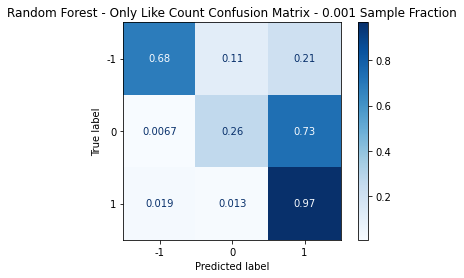

Random Forest - Only Like Count - 0.01 Sample Fraction metrics:
Accuracy Score: 0.8668915829409657
F1 scores: {'f1_weighted': 0.8440152295907999, 'f1_macro': 0.7019583397881942, 'f1_micro': 0.8668915829409657}
Random Forest - Only Like Count Confusion Matrix - 0.01 Sample Fraction
[[6.83862255e-01 1.05919424e-01 2.10218321e-01]
 [2.07965062e-04 2.56212956e-01 7.43579079e-01]
 [1.20442898e-03 5.64835658e-04 9.98230735e-01]]


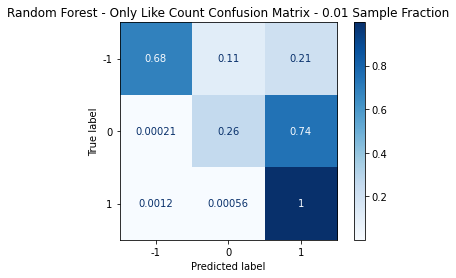

Random Forest - Only Like Count - 0.1 Sample Fraction metrics:
Accuracy Score: 0.8681088495903311
F1 scores: {'f1_weighted': 0.845124823426059, 'f1_macro': 0.7035079187438189, 'f1_micro': 0.8681088495903311}
Random Forest - Only Like Count Confusion Matrix - 0.1 Sample Fraction
[[6.83862255e-01 1.05919424e-01 2.10218321e-01]
 [0.00000000e+00 2.56160965e-01 7.43839035e-01]
 [5.81448471e-05 6.64512539e-05 9.99875404e-01]]


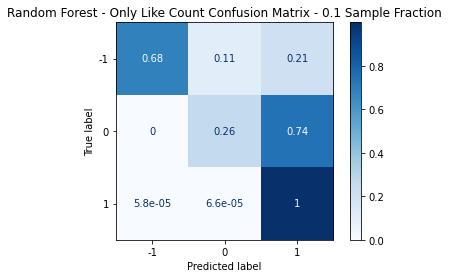

Random Forest - Only Like Count - 1 Sample Fraction metrics:
Accuracy Score: 0.8681459237014792
F1 scores: {'f1_weighted': 0.8451572447379742, 'f1_macro': 0.7035465580821506, 'f1_micro': 0.8681459237014792}
Random Forest - Only Like Count Confusion Matrix - 1 Sample Fraction
[[6.83862255e-01 1.05919424e-01 2.10218321e-01]
 [0.00000000e+00 2.56108974e-01 7.43891026e-01]
 [0.00000000e+00 6.64512539e-05 9.99933549e-01]]


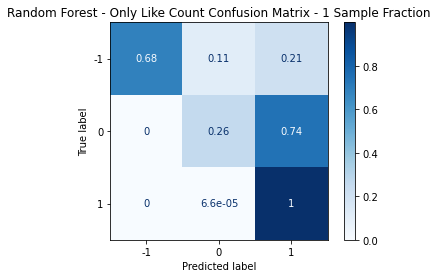

,Sample Fraction,Accuracy,F1 Macro,F1 Micro,F1 Weighted,MCC,Number of Rows
0,0.0001,0.7985,0.5129,0.7985,0.7572,0.5051,82.0000
1,0.0010,0.8447,0.6768,0.8447,0.8251,0.5853,815.0000
2,0.0100,0.8669,0.7020,0.8669,0.8440,0.6500,8152.0000
3,0.1000,0.8681,0.7035,0.8681,0.8451,0.6539,81519.0000
4,1.0000,0.8681,0.7035,0.8681,0.8452,0.6541,815194.0000


In [61]:
rf_frac_dict_onlylikecount = train_sample_fracs(rf_clf,training_fracs,"Random Forest - Only Like Count",random_state,["like_count"])

# Plot metrics with sample fraction
pd.set_option('display.float_format', lambda x: '%.4f' % x)

rf_sample_metric_df = pd.DataFrame(rf_frac_dict_onlylikecount).transpose().reset_index()
rf_sample_metric_df.columns = ["Sample Fraction","Accuracy","F1 Macro","F1 Micro", "F1 Weighted","MCC","Number of Rows"]
display(rf_sample_metric_df)

### GBM

/home/james/miniconda3/envs/huggingface/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



GBM metrics:
Accuracy Score: 0.8460682905127349
F1 score: 0.8195560922076384
GBM Confusion Matrix
[[0.82741391 0.04668017 0.12590592]
 [0.24597068 0.16595612 0.5880732 ]
 [0.0400618  0.00176926 0.95816894]]


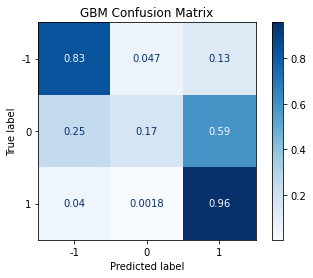

In [695]:
# Training model
# Params Based on previous gridsearch cvs
gbm_model = lgb.LGBMClassifier(learning_rate=0.05,
#                                max_depth=6,
#                                max_depth=20,
#                                min_child_samples=5,
                               num_leaves=100,
#                                reg_alpha=0.6,
#                                reg_alpha=0.03,
#                                reg_lambda=0.005,
                               random_state=random_state)
gbm_model.fit(training_df[X_cols],training_df[y_col], verbose=20,eval_metric='logloss')

# Testing model
gbm_acc,gbm_f1,gbm_mcc = test_model_metrics(gbm_model,"GBM",testing_df[X_cols],testing_df[y_col])

disp = ConfusionMatrixDisplay.from_estimator(
    gbm_model,
    testing_df[X_cols],
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("GBM Confusion Matrix")

print("GBM Confusion Matrix")
print(disp.confusion_matrix)

/home/james/miniconda3/envs/huggingface/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


GBM-Scaled metrics:
Accuracy Score: 0.8454503886602652
F1 score: 0.8183473031521911
GBM Confusion Matrix-Scaled
[[0.83056493 0.04424938 0.12518569]
 [0.25111781 0.15997712 0.58890506]
 [0.04094228 0.00134564 0.95771208]]


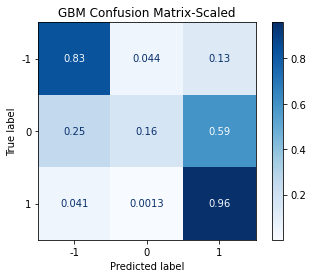

In [524]:
# Training model - scaled version
# Params Based on previous gridsearch cvs
gbm_model = lgb.LGBMClassifier(learning_rate=0.05,
                               max_depth=20,
                               min_child_samples=15,
                               num_leaves=100,
                               reg_alpha=0.03,
                               random_state=random_state)
gbm_model.fit(training_df_scaled_X,training_df[y_col], verbose=20,eval_metric='logloss')

# Testing model
gbm_acc,gbm_f1,gbm_mcc = test_model_metrics(gbm_model,"GBM-Scaled",testing_df_scaled_X,testing_df[y_col])

disp = ConfusionMatrixDisplay.from_estimator(
    gbm_model,
    testing_df_scaled_X,
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("GBM Confusion Matrix-Scaled")

print("GBM Confusion Matrix-Scaled")
print(disp.confusion_matrix)

### Neural Net
We will use sklearn mlp and fastai to create a tabular learner neural net

Iteration 1, loss = 4.16674428
Iteration 2, loss = 3.75294739
Iteration 3, loss = 3.72881356
Iteration 4, loss = 3.57791760
Iteration 5, loss = 3.68426200
Iteration 6, loss = 3.53148065
Iteration 7, loss = 3.55388984
Iteration 8, loss = 3.50826334
Iteration 9, loss = 3.59116912
Iteration 10, loss = 3.45132756
Iteration 11, loss = 3.39666008
Iteration 12, loss = 3.29735572
Iteration 13, loss = 3.16681682
Iteration 14, loss = 3.31168337
Iteration 15, loss = 3.05299729
Iteration 16, loss = 2.90193616
Iteration 17, loss = 2.81601429
Iteration 18, loss = 3.00296828
Iteration 19, loss = 3.10721858
Iteration 20, loss = 2.85991936
Iteration 21, loss = 2.97146478
Iteration 22, loss = 2.57083000
Iteration 23, loss = 2.68359851
Iteration 24, loss = 3.00680753
Iteration 25, loss = 2.81650173
Iteration 26, loss = 2.90995536
Iteration 27, loss = 3.03275350
Iteration 28, loss = 3.16004897
Iteration 29, loss = 3.30532789
Iteration 30, loss = 3.02300472
Iteration 31, loss = 3.08278021
Iteration 32, los

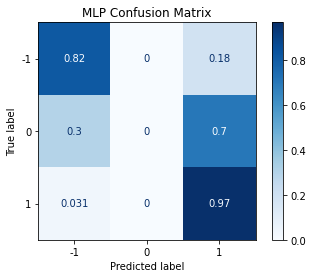

In [696]:
%%time
# Starting with Sklearn MLP
# Training model
mlp_clf = MLPClassifier(random_state=random_state, max_iter=300, verbose=2)
mlp_clf.fit(training_df[X_cols],training_df[y_col])

# Testing model
mlp_acc,mlp_f1,mlp_mcc = test_model_metrics(mlp_clf,"MLP",testing_df[X_cols],testing_df[y_col])

disp = ConfusionMatrixDisplay.from_estimator(
    mlp_clf,
    testing_df[X_cols],
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("MLP Confusion Matrix")

print("MLP Confusion Matrix")
print(disp.confusion_matrix)

In [408]:
mlp_scaled_best_params

NameError: name 'mlp_scaled_best_params' is not defined

#### MLP

Iteration 1, loss = 2.93986749
Iteration 2, loss = 2.28064059
Iteration 3, loss = 1.39294104
Iteration 4, loss = 0.31752034
Iteration 5, loss = 0.28707295
Iteration 6, loss = 0.27952369
Iteration 7, loss = 0.28934666
Iteration 8, loss = 0.28609324
Iteration 9, loss = 0.27966617
Iteration 10, loss = 0.28116586
Iteration 11, loss = 0.28283150
Iteration 12, loss = 0.27835285
Iteration 13, loss = 0.28233675
Iteration 14, loss = 0.28493140
Iteration 15, loss = 0.28452173
Iteration 16, loss = 0.27099934
Iteration 17, loss = 0.26452064
Iteration 18, loss = 0.26661840
Iteration 19, loss = 0.27448079
Iteration 20, loss = 0.26773580
Iteration 21, loss = 0.26194816
Iteration 22, loss = 0.26036246
Iteration 23, loss = 0.26125854
Iteration 24, loss = 0.25890214
Iteration 25, loss = 0.25349210
Iteration 26, loss = 0.25724975
Iteration 27, loss = 0.25799354
Iteration 28, loss = 0.24923867
Iteration 29, loss = 0.25872487
Iteration 30, loss = 0.25787797
Iteration 31, loss = 0.25739950
Iteration 32, los

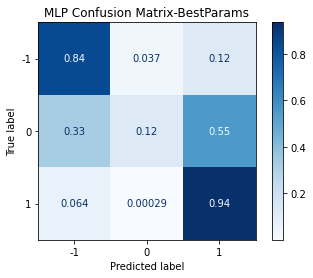

In [809]:
%%time
# Starting with Sklearn MLP
# Training model
mlp_clf = MLPClassifier(random_state=random_state, 
                        max_iter=300, 
                        verbose=2,
                        activation="relu",
#                         hidden_layer_sizes=(5,3,),
                        hidden_layer_sizes=(10,10,10),
                        learning_rate="adaptive",
                        alpha=0.0001)

mlp_clf.fit(training_df[X_cols],training_df[y_col])

# Testing model
mlp_acc,mlp_f1,mlp_mcc = test_model_metrics(mlp_clf,"MLP-BestParams",testing_df[X_cols],testing_df[y_col])

disp = ConfusionMatrixDisplay.from_estimator(
    mlp_clf,
    testing_df[X_cols],
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("MLP Confusion Matrix-BestParams")

print("MLP Confusion Matrix-BestParams")
print(disp.confusion_matrix)

#### MLP with Scaled X

Iteration 1, loss = 0.57327166
Iteration 2, loss = 0.42688498
Iteration 3, loss = 0.40550325
Iteration 4, loss = 0.39486817
Iteration 5, loss = 0.38795977
Iteration 6, loss = 0.38239646
Iteration 7, loss = 0.37798522
Iteration 8, loss = 0.37397693
Iteration 9, loss = 0.37001959
Iteration 10, loss = 0.36541966
Iteration 11, loss = 0.36147759
Iteration 12, loss = 0.35692697
Iteration 13, loss = 0.35318781
Iteration 14, loss = 0.35010806
Iteration 15, loss = 0.34768833
Iteration 16, loss = 0.34551324
Iteration 17, loss = 0.34344690
Iteration 18, loss = 0.34161080
Iteration 19, loss = 0.34026153
Iteration 20, loss = 0.33886809
Iteration 21, loss = 0.33736581
Iteration 22, loss = 0.33597214
Iteration 23, loss = 0.33490787
Iteration 24, loss = 0.33384561
Iteration 25, loss = 0.33236697
Iteration 26, loss = 0.33195738
Iteration 27, loss = 0.33133361
Iteration 28, loss = 0.33084356
Iteration 29, loss = 0.32985051
Iteration 30, loss = 0.32955512
Iteration 31, loss = 0.32874117
Iteration 32, los

Iteration 253, loss = 0.29756509
Iteration 254, loss = 0.29706828
Iteration 255, loss = 0.29739032
Iteration 256, loss = 0.29894419
Iteration 257, loss = 0.29760509
Iteration 258, loss = 0.29793902
Iteration 259, loss = 0.29755837
Iteration 260, loss = 0.29742555
Iteration 261, loss = 0.29853800
Iteration 262, loss = 0.29670035
Iteration 263, loss = 0.29695491
Iteration 264, loss = 0.29677631
Iteration 265, loss = 0.29704679
Iteration 266, loss = 0.29652694
Iteration 267, loss = 0.29641700
Iteration 268, loss = 0.29692576
Iteration 269, loss = 0.29764232
Iteration 270, loss = 0.29713878
Iteration 271, loss = 0.29761846
Iteration 272, loss = 0.29684831
Iteration 273, loss = 0.29762397
Iteration 274, loss = 0.29782719
Iteration 275, loss = 0.29667815
Iteration 276, loss = 0.29622156
Iteration 277, loss = 0.29767060
Iteration 278, loss = 0.29691062
Iteration 279, loss = 0.29632186
Iteration 280, loss = 0.29645319
Iteration 281, loss = 0.29675032
Iteration 282, loss = 0.29764790
Iteration 

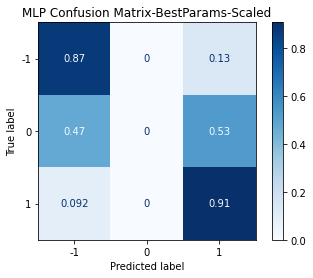

In [698]:
%%time
# Starting with Sklearn MLP
# Training model
mlp_clf = MLPClassifier(random_state=random_state, 
                        max_iter=300, 
                        verbose=2,
                        activation="relu",
                        hidden_layer_sizes=(5,3,),
                        learning_rate="adaptive",
                        alpha=0.0001)

mlp_clf.fit(training_df_scaled_X,training_df[y_col])

# Testing model
mlp_acc,mlp_f1,mlp_mcc = test_model_metrics(mlp_clf,"MLP-BestParams-Scaled",testing_df_scaled_X,testing_df[y_col])

disp = ConfusionMatrixDisplay.from_estimator(
    mlp_clf,
    testing_df_scaled_X,
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("MLP Confusion Matrix-BestParams-Scaled")

print("MLP Confusion Matrix-BestParams-Scaled")
print(disp.confusion_matrix)

Iteration 1, loss = 0.47297872
Iteration 2, loss = 0.40710447
Iteration 3, loss = 0.38969220
Iteration 4, loss = 0.37782716
Iteration 5, loss = 0.36838334
Iteration 6, loss = 0.36109576
Iteration 7, loss = 0.35448279
Iteration 8, loss = 0.34894745
Iteration 9, loss = 0.34410253
Iteration 10, loss = 0.33978136
Iteration 11, loss = 0.33579144
Iteration 12, loss = 0.33251069
Iteration 13, loss = 0.32936043
Iteration 14, loss = 0.32648606
Iteration 15, loss = 0.32380632
Iteration 16, loss = 0.32144675
Iteration 17, loss = 0.31969634
Iteration 18, loss = 0.31759298
Iteration 19, loss = 0.31603363
Iteration 20, loss = 0.31473164
Iteration 21, loss = 0.31337833
Iteration 22, loss = 0.31250939
Iteration 23, loss = 0.31153681
Iteration 24, loss = 0.31021413
Iteration 25, loss = 0.30896504
Iteration 26, loss = 0.30821295
Iteration 27, loss = 0.30741706
Iteration 28, loss = 0.30635135
Iteration 29, loss = 0.30594061
Iteration 30, loss = 0.30542232
Iteration 31, loss = 0.30480363
Iteration 32, los

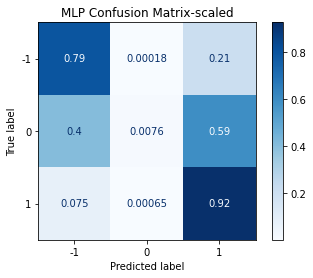

In [382]:
%%time 
# Starting with Sklearn MLP
# Training model
mlp_clf = MLPClassifier(random_state=random_state, max_iter=300, verbose=10)
mlp_clf.fit(training_df_scaled_X,training_df[y_col])

# Testing model
mlp_acc,mlp_f1,mlp_mcc = test_model_metrics(mlp_clf,"MLP-scaled",testing_df_scaled_X,testing_df[y_col])

disp = ConfusionMatrixDisplay.from_estimator(
    mlp_clf,
    testing_df_scaled_X,
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("MLP Confusion Matrix-scaled")

print("MLP Confusion Matrix-scaled")
print(disp.confusion_matrix)

Iteration 1, loss = 0.40701400
Iteration 2, loss = 0.31252940
Iteration 3, loss = 0.30277185
Iteration 4, loss = 0.30906611
Iteration 5, loss = 0.29275641
Iteration 6, loss = 0.28824150
Iteration 7, loss = 0.28439195
Iteration 8, loss = 0.29689165
Iteration 9, loss = 0.27265937
Iteration 10, loss = 0.28276546
Iteration 11, loss = 0.28344491
Iteration 12, loss = 0.30125225
Iteration 13, loss = 0.28142215
Iteration 14, loss = 0.27446613
Iteration 15, loss = 0.27726245
Iteration 16, loss = 0.27750526
Iteration 17, loss = 0.27472576
Iteration 18, loss = 0.29798478
Iteration 19, loss = 0.27344115
Iteration 20, loss = 0.27723733
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.33151311
Iteration 2, loss = 0.28947453
Iteration 3, loss = 0.27905612
Iteration 4, loss = 0.27487679
Iteration 5, loss = 0.27349553
Iteration 6, loss = 0.27349734
Iteration 7, loss = 0.26545096
Iteration 8, loss = 0.26780056
Iteration 9, loss = 0.27019535


Iteration 5, loss = 0.29190243Iteration 1, loss = 0.45841544
Iteration 2, loss = 0.34654656
Iteration 3, loss = 0.31394718
Iteration 4, loss = 0.28977850
Iteration 5, loss = 0.29568180
Iteration 6, loss = 0.31243977
Iteration 7, loss = 0.30642095
Iteration 8, loss = 0.29913575
Iteration 9, loss = 0.29182255
Iteration 10, loss = 0.29886972
Iteration 11, loss = 0.29874969
Iteration 12, loss = 0.28401646
Iteration 13, loss = 0.28735091
Iteration 14, loss = 0.29277096
Iteration 15, loss = 0.28090091
Iteration 16, loss = 0.28376037
Iteration 17, loss = 0.29561624
Iteration 18, loss = 0.27745587
Iteration 19, loss = 0.27463096
Iteration 20, loss = 0.27954703
Iteration 21, loss = 0.28071557
Iteration 22, loss = 0.27581267
Iteration 23, loss = 0.28211803
Iteration 24, loss = 0.27460174
Iteration 25, loss = 0.27419507
Iteration 26, loss = 0.28064788
Iteration 27, loss = 0.27651367
Iteration 28, loss = 0.27514478
Iteration 29, loss = 0.27130439
Iteration 30, loss = 0.26952141
Iteration 31, loss 

Iteration 1, loss = 0.45841544
Iteration 2, loss = 0.34654656
Iteration 3, loss = 0.31394718
Iteration 4, loss = 0.28977850
Iteration 5, loss = 0.29568180
Iteration 6, loss = 0.31243977
Iteration 7, loss = 0.30642095
Iteration 8, loss = 0.29913575
Iteration 9, loss = 0.29182255
Iteration 10, loss = 0.29886972
Iteration 11, loss = 0.29874969
Iteration 12, loss = 0.28401646
Iteration 13, loss = 0.28735091
Iteration 14, loss = 0.29277096
Iteration 15, loss = 0.28090091
Iteration 16, loss = 0.28376037
Iteration 17, loss = 0.29561624
Iteration 18, loss = 0.27745587
Iteration 19, loss = 0.27463096
Iteration 20, loss = 0.27954703
Iteration 21, loss = 0.28071557
Iteration 22, loss = 0.27581267
Iteration 23, loss = 0.28211803
Iteration 24, loss = 0.27460174
Iteration 25, loss = 0.27419507
Iteration 26, loss = 0.28064788
Iteration 27, loss = 0.27651367
Iteration 28, loss = 0.27514478
Iteration 29, loss = 0.27130439
Iteration 30, loss = 0.26952141
Iteration 31, loss = 0.27813779
Iteration 32, los

Iteration 1, loss = 0.39242055
Iteration 2, loss = 0.31204405
Iteration 3, loss = 0.28957022
Iteration 4, loss = 0.29374337
Iteration 5, loss = 0.29989757
Iteration 6, loss = 0.29258826
Iteration 7, loss = 0.28457235
Iteration 8, loss = 0.29022549
Iteration 9, loss = 0.28188179
Iteration 10, loss = 0.26999265
Iteration 11, loss = 0.27272760
Iteration 12, loss = 0.27325180
Iteration 13, loss = 0.27196838
Iteration 14, loss = 0.28348588
Iteration 15, loss = 0.27541411
Iteration 16, loss = 0.27938415
Iteration 17, loss = 0.26783011
Iteration 18, loss = 0.26672062
Iteration 19, loss = 0.27240025
Iteration 20, loss = 0.27135273
Iteration 21, loss = 0.27228484
Iteration 22, loss = 0.27035860
Iteration 23, loss = 0.27653132
Iteration 24, loss = 0.26120957
Iteration 25, loss = 0.27231464
Iteration 26, loss = 0.26824774
Iteration 27, loss = 0.26252530
Iteration 28, loss = 0.27605703
Iteration 29, loss = 0.27084002
Iteration 30, loss = 0.26141037
Iteration 31, loss = 0.27804010
Iteration 32, los

Iteration 1, loss = 0.43228643
Iteration 2, loss = 0.32308270
Iteration 3, loss = 0.31103518
Iteration 4, loss = 0.31969680
Iteration 5, loss = 0.31817753
Iteration 6, loss = 0.29652956
Iteration 7, loss = 0.28340677
Iteration 8, loss = 0.28506687
Iteration 9, loss = 0.29999942
Iteration 10, loss = 0.29030464
Iteration 11, loss = 0.28989360
Iteration 12, loss = 0.28486162
Iteration 13, loss = 0.28209297
Iteration 14, loss = 0.28262956
Iteration 15, loss = 0.27798160
Iteration 16, loss = 0.27096726
Iteration 17, loss = 0.26611379
Iteration 18, loss = 0.28328057
Iteration 19, loss = 0.26881195
Iteration 20, loss = 0.27464903
Iteration 21, loss = 0.27106633
Iteration 22, loss = 0.26892023
Iteration 23, loss = 0.27653037
Iteration 24, loss = 0.27241722
Iteration 25, loss = 0.26666767
Iteration 26, loss = 0.26336568
Iteration 27, loss = 0.27374789
Iteration 28, loss = 0.27803383
Iteration 29, loss = 0.27297842
Iteration 30, loss = 0.27108207
Iteration 31, loss = 0.26726562
Iteration 32, los

Iteration 1, loss = 0.42151894
Iteration 2, loss = 0.34186727
Iteration 3, loss = 0.31679228
Iteration 4, loss = 0.30287305
Iteration 5, loss = 0.29309950
Iteration 6, loss = 0.28576152
Iteration 7, loss = 0.28978015
Iteration 8, loss = 0.28198268
Iteration 9, loss = 0.28089363
Iteration 10, loss = 0.27712700
Iteration 11, loss = 0.27628600
Iteration 12, loss = 0.29583465
Iteration 13, loss = 0.28339407
Iteration 14, loss = 0.28101336
Iteration 15, loss = 0.27754933
Iteration 16, loss = 0.27840929
Iteration 17, loss = 0.28164941
Iteration 18, loss = 0.28252430
Iteration 19, loss = 0.27841760
Iteration 20, loss = 0.28397716
Iteration 21, loss = 0.27713089
Iteration 22, loss = 0.27606080
Iteration 23, loss = 0.27220012
Iteration 24, loss = 0.26823327
Iteration 25, loss = 0.27431739
Iteration 26, loss = 0.26965281
Iteration 27, loss = 0.26360360
Iteration 28, loss = 0.26928454
Iteration 29, loss = 0.26748154
Iteration 30, loss = 0.26909094
Iteration 31, loss = 0.26898226
Iteration 32, los

Iteration 1, loss = 0.39242055
Iteration 2, loss = 0.31204405
Iteration 3, loss = 0.28957022
Iteration 4, loss = 0.29374337
Iteration 5, loss = 0.29989757
Iteration 6, loss = 0.29258826
Iteration 7, loss = 0.28457235
Iteration 8, loss = 0.29022549
Iteration 9, loss = 0.28188179
Iteration 10, loss = 0.26999265
Iteration 11, loss = 0.27272760
Iteration 12, loss = 0.27325180
Iteration 13, loss = 0.27196838
Iteration 14, loss = 0.28348588
Iteration 15, loss = 0.27541411
Iteration 16, loss = 0.27938415
Iteration 17, loss = 0.26783011
Iteration 18, loss = 0.26672062
Iteration 19, loss = 0.27240025
Iteration 20, loss = 0.27135273
Iteration 21, loss = 0.27228484
Iteration 22, loss = 0.27035860
Iteration 23, loss = 0.27653132
Iteration 24, loss = 0.26120957
Iteration 25, loss = 0.27231464
Iteration 26, loss = 0.26824774
Iteration 27, loss = 0.26252530
Iteration 28, loss = 0.27605703
Iteration 29, loss = 0.27084002
Iteration 30, loss = 0.26141037
Iteration 31, loss = 0.27804010
Iteration 32, los

Iteration 20, loss = 0.28042078
Iteration 21, loss = 0.27569442
Iteration 22, loss = 0.27933167
Iteration 23, loss = 0.27792424
Iteration 24, loss = 0.27968770
Iteration 25, loss = 0.27708390
Iteration 26, loss = 0.28308456
Iteration 27, loss = 0.28120179
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 3.26128764
Iteration 2, loss = 1.03597093
Iteration 3, loss = 0.63149425
Iteration 4, loss = 0.59722453
Iteration 5, loss = 0.59435127
Iteration 6, loss = 0.58778426
Iteration 7, loss = 0.58463501
Iteration 8, loss = 0.56724102
Iteration 9, loss = 0.57630242
Iteration 10, loss = 0.57626226
Iteration 11, loss = 0.55846420
Iteration 12, loss = 0.54905214
Iteration 13, loss = 0.56347716
Iteration 14, loss = 0.56043639
Iteration 15, loss = 0.46378976
Iteration 16, loss = 0.41582934
Iteration 17, loss = 0.41831270
Iteration 18, loss = 0.39833979
Iteration 19, loss = 0.39844558
Iteration 20, loss = 0.42383444
Iteration 21, loss = 0.

Iteration 48, loss = 0.28155430
Iteration 49, loss = 0.27600521
Iteration 50, loss = 0.26775796
Iteration 51, loss = 0.26161241
Iteration 52, loss = 0.28481188
Iteration 53, loss = 0.29014417
Iteration 54, loss = 0.27205913
Iteration 55, loss = 0.26466583
Iteration 56, loss = 0.25918039
Iteration 57, loss = 0.26151096
Iteration 58, loss = 0.26228186
Iteration 59, loss = 0.26331525
Iteration 60, loss = 0.25875009
Iteration 61, loss = 0.25641850
Iteration 62, loss = 0.26125741
Iteration 63, loss = 0.26637000
Iteration 64, loss = 0.26322905
Iteration 65, loss = 0.25856132
Iteration 66, loss = 0.25992137
Iteration 67, loss = 0.26505743
Iteration 68, loss = 0.25805234
Iteration 69, loss = 0.26054176
Iteration 70, loss = 0.25538632
Iteration 71, loss = 0.26537055
Iteration 72, loss = 0.25992874
Iteration 73, loss = 0.26612860
Iteration 74, loss = 0.25960155
Iteration 75, loss = 0.25761366
Iteration 76, loss = 0.25550727
Iteration 77, loss = 0.26007770
Iteration 78, loss = 0.26051240
Iteratio

Iteration 4, loss = 0.51532897
Iteration 5, loss = 0.45662602
Iteration 6, loss = 0.44074748
Iteration 7, loss = 0.38952303
Iteration 8, loss = 0.35552700
Iteration 9, loss = 0.37544397
Iteration 10, loss = 0.36104833
Iteration 11, loss = 0.34926239
Iteration 12, loss = 0.35322118
Iteration 13, loss = 0.34761807
Iteration 14, loss = 0.37255946
Iteration 15, loss = 0.33101116
Iteration 16, loss = 0.31430193
Iteration 17, loss = 0.32052047
Iteration 18, loss = 0.30944213
Iteration 19, loss = 0.30697693
Iteration 20, loss = 0.33581713
Iteration 21, loss = 0.33031619
Iteration 22, loss = 0.32358899
Iteration 23, loss = 0.31380988
Iteration 24, loss = 0.30066387
Iteration 25, loss = 0.28981257
Iteration 26, loss = 0.31025298
Iteration 27, loss = 0.29804076
Iteration 28, loss = 0.29650502
Iteration 29, loss = 0.29480945
Iteration 30, loss = 0.28688976
Iteration 31, loss = 0.28709372
Iteration 32, loss = 0.27866164
Iteration 33, loss = 0.27312111
Iteration 34, loss = 0.31659889
Iteration 35, 

Iteration 23, loss = 0.28182723
Iteration 24, loss = 0.27821578
Iteration 25, loss = 0.28814125
Iteration 26, loss = 0.28696574
Iteration 27, loss = 0.27912478
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 3.54433163
Iteration 2, loss = 1.23369870
Iteration 3, loss = 0.54347917
Iteration 4, loss = 0.46718929
Iteration 5, loss = 0.44809008
Iteration 6, loss = 0.40219987
Iteration 7, loss = 0.43904978
Iteration 8, loss = 0.36968434
Iteration 9, loss = 0.35539988
Iteration 10, loss = 0.33723355
Iteration 11, loss = 0.37337154
Iteration 12, loss = 0.32009673
Iteration 13, loss = 0.36363730
Iteration 14, loss = 0.32885513
Iteration 15, loss = 0.33645709
Iteration 16, loss = 0.33316510
Iteration 17, loss = 0.35240865
Iteration 18, loss = 0.33077383
Iteration 19, loss = 0.34145935
Iteration 20, loss = 0.34463674
Iteration 21, loss = 0.34317202
Iteration 22, loss = 0.32428196
Iteration 23, loss = 0.30767372
Iteration 24, loss = 0.

Iteration 38, loss = 3.01954100
Iteration 39, loss = 2.71593628
Iteration 40, loss = 2.99600454
Iteration 41, loss = 2.97198114
Iteration 42, loss = 3.21064866
Iteration 43, loss = 3.11409320
Iteration 44, loss = 3.20966350
Iteration 45, loss = 2.89522614
Iteration 46, loss = 3.17020376
Iteration 47, loss = 3.09535598
Iteration 48, loss = 3.06522461
Iteration 49, loss = 3.12517354
Iteration 50, loss = 2.85844845
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 3.26128764
Iteration 2, loss = 1.03597093
Iteration 3, loss = 0.63149425
Iteration 4, loss = 0.59722453
Iteration 5, loss = 0.59435127
Iteration 6, loss = 0.58778426
Iteration 7, loss = 0.58463501
Iteration 8, loss = 0.56724102
Iteration 9, loss = 0.57630242
Iteration 10, loss = 0.57626226
Iteration 11, loss = 0.55846420
Iteration 12, loss = 0.54905214
Iteration 13, loss = 0.563477

Iteration 1, loss = 2.56605442
Iteration 2, loss = 1.07074700
Iteration 3, loss = 0.46292353
Iteration 4, loss = 0.40393295
Iteration 5, loss = 0.37326466
Iteration 6, loss = 0.33711878
Iteration 7, loss = 0.33769246
Iteration 8, loss = 0.34503669
Iteration 9, loss = 0.33290654
Iteration 10, loss = 0.32389803
Iteration 11, loss = 0.32224167
Iteration 12, loss = 0.30627045
Iteration 13, loss = 0.30285902
Iteration 14, loss = 0.30704280
Iteration 15, loss = 0.30248151
Iteration 16, loss = 0.29078148
Iteration 17, loss = 0.30065069
Iteration 18, loss = 0.30811866
Iteration 19, loss = 0.31075496
Iteration 20, loss = 0.29370550
Iteration 21, loss = 0.28932057
Iteration 22, loss = 0.31667767
Iteration 23, loss = 0.28917095
Iteration 24, loss = 0.29381728
Iteration 25, loss = 0.30530100
Iteration 26, loss = 0.30034973
Iteration 27, loss = 0.27716184
Iteration 28, loss = 0.28090427
Iteration 29, loss = 0.27790793
Iteration 30, loss = 0.27939208
Iteration 31, loss = 0.27257999
Iteration 32, los

Iteration 76, loss = 0.25320183
Iteration 77, loss = 0.25100673
Iteration 78, loss = 0.24707538
Iteration 79, loss = 0.24724871
Iteration 80, loss = 0.24598297
Iteration 81, loss = 0.24631310
Iteration 82, loss = 0.25814868
Iteration 83, loss = 0.25727503
Iteration 84, loss = 0.24900450
Iteration 85, loss = 0.25339651
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
MLP Scaled Best Params found through grid search cv are:
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 10, 10), 'learning_rate': 'constant'}
MLP-Gridsearch metrics:
Accuracy Score: 0.828581668087841
F1 score: 0.799191976639672
MLP Confusion Matrix-Gridsearch
[[8.37722260e-01 3.63718208e-02 1.25905919e-01]
 [3.15690964e-01 1.13652906e-01 5.70656130e-01]
 [5.88176661e-02 6.64512539e-05 9.41115883e-01]]


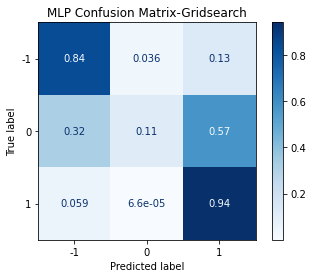

Iteration 32, loss = 0.26922311
Iteration 33, loss = 0.27111372
Iteration 34, loss = 0.27848335
Iteration 35, loss = 0.26453662
Iteration 36, loss = 0.27167554
Iteration 37, loss = 0.27504083
Iteration 38, loss = 0.27304957
Iteration 39, loss = 0.26102637
Iteration 40, loss = 0.26355637
Iteration 41, loss = 0.25886670
Iteration 42, loss = 0.27197636
Iteration 43, loss = 0.26509269
Iteration 44, loss = 0.27040923
Iteration 45, loss = 0.26027314
Iteration 46, loss = 0.26578179
Iteration 47, loss = 0.26304403
Iteration 48, loss = 0.27098182
Iteration 49, loss = 0.25686861
Iteration 50, loss = 0.25887245
Iteration 51, loss = 0.26960251
Iteration 52, loss = 0.27005669
Iteration 53, loss = 0.25519648
Iteration 54, loss = 0.26327628
Iteration 55, loss = 0.25664010
Iteration 56, loss = 0.26070010
Iteration 57, loss = 0.25805642
Iteration 58, loss = 0.25466238
Iteration 59, loss = 0.27238738
Iteration 60, loss = 0.25996688
Iteration 61, loss = 0.26579419
Iteration 62, loss = 0.26373347
Iteratio

In [35]:
# Gridsearch MLP
# Inspired by https://datascience.stackexchange.com/questions/36049/how-to-adjust-the-hyperparameters-of-mlp-classifier-to-get-more-perfect-performa
parameter_space = {
    'hidden_layer_sizes': [(10,10,10),(10,25,10),(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

mlp_base = MLPClassifier(random_state=random_state, max_iter=300, verbose=10)
mlp_clf_grid = GridSearchCV(mlp_base, parameter_space, n_jobs=-1, cv=3)
mlp_clf_grid.fit(training_df[X_cols],training_df[y_col])

mlp_scaled_best_params = mlp_clf_grid.best_params_
print("MLP Scaled Best Params found through grid search cv are:")
print(mlp_scaled_best_params)

# Testing model
mlp_acc_grid,mlp_f1_grid,mlp_mcc_grid = test_model_metrics(mlp_clf_grid,"MLP-Gridsearch",testing_df[X_cols],testing_df[y_col])

disp = ConfusionMatrixDisplay.from_estimator(
    mlp_clf_grid,
    testing_df[X_cols],
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("MLP Confusion Matrix-Gridsearch")

print("MLP Confusion Matrix-Gridsearch")
print(disp.confusion_matrix)


In [36]:
mlp_scaled_best_params

{'activation': 'relu',
 'alpha': 0.0001,
 'hidden_layer_sizes': (10, 10, 10),
 'learning_rate': 'constant'}

In [ ]:
MLP Scaled Best Params found through grid search cv are:
{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}

### Checking FastAI Tabular Learner

In [704]:
# Create dataframe with all required columns
tab_df = training_df[all_related_cols].copy()

def remap_target(value):
    if value == -1:
        return "Negative"
    elif value == 0:
        return "Neutral"
    elif value == 1:
        return "Positive"

# tab_df["ld_score_ohe"] = tab_df["ld_score_ohe"].apply(remap_target)

# Create tabular object and dataloaders
# cat_names = ['age_limit','is_comments_enabled','is_live_content','cat_codes','NoCommentsBinary']
cat_names = ['cat_codes','NoCommentsBinary']
cont_names = ['duration', 'view_count', 'like_count','view_like_ratio_smoothed','desc_compound','comment_compound','votes',]
procs = [Categorify, FillMissing, Normalize]

# Creates splits
# splits = RandomSplitter(valid_pct=0.1)(range_of(tab_df))
splits = TrainTestSplitter(test_size=0.1, random_state=random_state, stratify=tab_df["ld_score_ohe"])(range_of(tab_df))

to = TabularPandas(tab_df, procs=procs,
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names=y_col,
                   y_block=CategoryBlock,
                   splits=splits)

dls = to.dataloaders(bs=2048)

In [705]:
splits

((#733674) [594541,528923,275951,31576,586990,679439,276309,214856,517085,788880...],
 (#81520) [123431,601519,38726,683509,135328,388657,544081,460312,243370,402408...])

In [706]:
cross_entropy_loss_flat = CrossEntropyLossFlat()
f1_score_fai = F1Score()
f1_score_multi = F1ScoreMulti(average="weighted")

In [754]:
# Create tabular learner
learn_tab = tabular_learner(dls, layers=[10,50,10], metrics=accuracy,loss_func=cross_entropy_loss_flat)

SuggestedLRs(valley=0.005248074419796467)

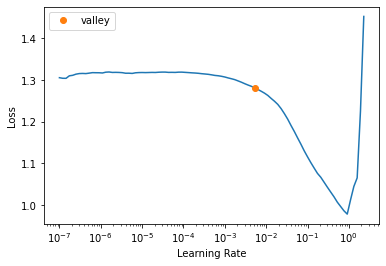

In [755]:
# Fastai has a useful function to estimate the best learning rate to use.
learn_tab.lr_find()

In [756]:
# Fit the data. We are not fine-tuning here. We are learning from our training data alone.
learn_tab.fit_one_cycle(10,1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.259314,1.242669,0.269112,00:04
1,1.089419,1.079071,0.493952,00:04
2,0.848837,0.952482,0.666229,00:04
3,0.704173,0.774941,0.765567,00:04
4,0.633908,0.651308,0.795424,00:04
5,0.578973,0.570212,0.814867,00:04
6,0.560748,0.574227,0.811053,00:04
7,0.539988,0.590541,0.797252,00:04
8,0.537372,0.571470,0.795633,00:04
9,0.533623,0.545137,0.814082,00:04


In [757]:
tab_test_df = testing_df[X_cols].copy()
tab_test_dl = learn_tab.dls.test_dl(tab_test_df,ordered=True)

In [758]:
preds, _, decoded = learn_tab.get_preds(dl=tab_test_dl, with_decoded=True)

In [759]:
from collections import Counter

In [760]:
decoded

tensor([2, 2, 2,  ..., 0, 2, 2])

In [761]:
decoded.unique()

tensor([0, 1, 2])

In [762]:
Counter(decoded.numpy())

Counter({2: 117729, 0: 44083, 1: 26})

In [763]:
decoded[decoded == 0] = -1
decoded[decoded == 1] = 0
decoded[decoded == 2] = 1

In [764]:
decoded.unique()

tensor([-1,  0,  1])

In [765]:
Counter(decoded.numpy())

Counter({1: 117729, -1: 44083, 0: 26})

Tabular Model - FastAi - F1 Weighted Score: 0.6444048623348881
Tabular Model - FastAi - Confusion Matrix
[[5.27211344e-01 4.50146298e-05 4.72743642e-01]
 [3.83175626e-01 2.07965062e-04 6.16616408e-01]
 [2.07668475e-01 1.74434541e-04 7.92157091e-01]]


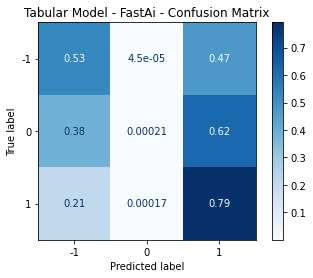

In [766]:
disp = ConfusionMatrixDisplay.from_predictions(
    testing_df[y_col],
    decoded.numpy(),
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("Tabular Model - FastAi - Confusion Matrix")
tab_f1 = f1_score(testing_df[y_col],decoded.numpy(),average="weighted")
tab_mcc = matthews_corrcoef(testing_df[y_col],decoded.numpy())
print(f"Tabular Model - FastAi - F1 Weighted Score: {tab_f1}")
print(f"Tabular Model - FastAi - MCC: {tab_mcc}")
print("Tabular Model - FastAi - Confusion Matrix")
print(disp.confusion_matrix)

### HuggingFace Transformer
We were interested if formatting the inputs as a string and put through a transformer would work.
Based on tutorials by Jeremy Howard: https://www.kaggle.com/code/jhoward/iterate-like-a-grandmaster/

In [767]:
%%time
from torch.utils.data import DataLoader
import warnings,transformers,logging,torch
from transformers import TrainingArguments,Trainer
from transformers import AutoModelForSequenceClassification,AutoTokenizer

CPU times: user 30 µs, sys: 10 µs, total: 40 µs
Wall time: 43.4 µs


In [768]:
import datasets
from datasets import load_dataset, Dataset, DatasetDict

In [769]:
import torch
torch.cuda.is_available()

True

In [424]:
dl_model_name = 'microsoft/deberta-v3-small'

In [425]:
tokz = AutoTokenizer.from_pretrained(dl_model_name)

loading configuration file https://huggingface.co/microsoft/deberta-v3-small/resolve/main/config.json from cache at /home/james/.cache/huggingface/transformers/8e0c12a7672d1d36f647c86e5fc3a911f189d8704e2bc94dde4a1ffe38f648fa.9df96bac06c2c492bc77ad040068f903c93beec14607428f25bf9081644ad0da
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-small",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "sha

In [770]:
sep = tokz.sep_token
sep

'[SEP]'

In [771]:
training_df_str = training_df[X_cols].round(2).astype(str)
training_df_str["ld_score_ohe"] = training_df["ld_score_ohe"].astype(float)

In [772]:
testing_df_str = testing_df[X_cols].round(2).astype(str)
testing_df_str["ld_score_ohe"] = testing_df["ld_score_ohe"].astype(float)

In [608]:
def inputstring(df,cols,sep):
    for c in cols:
        if "inputs" in df.columns:
            df["inputs"] = df["inputs"] + sep + df[c]
        else:
            df["inputs"] = df[c]
    return df
    

In [773]:
training_df_str_ = inputstring(training_df_str,X_cols,sep)
testing_df_str = inputstring(testing_df_str,X_cols,sep)

In [775]:
training_df_str.head()

,duration,view_count,like_count,view_like_ratio_smoothed,cat_codes,desc_neu,desc_neg,desc_pos,desc_compound,comment_neu,comment_neg,comment_pos,comment_compound,votes,NoCommentsBinary,ld_score_ohe,inputs
0,230,9146,757,12.08,1,0.72,0.09,0.19,0.98,0.64,0.04,0.32,0.66,114.0,0,1.00,230[SEP]9146[SEP]757[SEP]12.08[SEP]1[SEP]0.72[SEP]0.09[SEP]0.19[SEP]0.98[SEP]0.64[SEP]0.04[SEP]0.32[SEP]0.66[SEP]114.0[SEP]0
1,732,165,0,166.0,27,0.76,0.1,0.14,0.15,0.0,0.0,0.0,0.0,0.0,1,-1.00,732[SEP]165[SEP]0[SEP]166.0[SEP]27[SEP]0.76[SEP]0.1[SEP]0.14[SEP]0.15[SEP]0.0[SEP]0.0[SEP]0.0[SEP]0.0[SEP]0.0[SEP]1
2,973,20251,2492,8.13,24,0.95,0.0,0.05,0.81,0.99,0.0,0.01,0.07,11.4,0,1.00,973[SEP]20251[SEP]2492[SEP]8.13[SEP]24[SEP]0.95[SEP]0.0[SEP]0.05[SEP]0.81[SEP]0.99[SEP]0.0[SEP]0.01[SEP]0.07[SEP]11.4[SEP]0
3,243,20860,1596,13.07,10,0.62,0.06,0.32,0.87,0.67,0.04,0.29,0.65,178.4,0,1.00,243[SEP]20860[SEP]1596[SEP]13.07[SEP]10[SEP]0.62[SEP]0.06[SEP]0.32[SEP]0.87[SEP]0.67[SEP]0.04[SEP]0.29[SEP]0.65[SEP]178.4[SEP]0
4,44,58203,377,154.38,24,0.95,0.0,0.05,0.59,0.0,0.0,0.0,0.0,0.0,1,1.00,44[SEP]58203[SEP]377[SEP]154.38[SEP]24[SEP]0.95[SEP]0.0[SEP]0.05[SEP]0.59[SEP]0.0[SEP]0.0[SEP]0.0[SEP]0.0[SEP]0.0[SEP]1


In [776]:
_,_,X_train,X_eval,y_train,y_eval = create_training_test_sets(
    df=training_df_str,
    X_cols=["inputs"],
    y_col=y_col,
    random_state=random_state)

Splits created


In [777]:
split_train = pd.concat([X_train,y_train], axis=1)
split_eval = pd.concat([X_eval,y_eval], axis=1)

In [778]:
split_train.head(2)

,inputs,ld_score_ohe
479826,213[SEP]2869[SEP]5[SEP]573.8[SEP]22[SEP]0.64[SEP]0.36[SEP]0.0[SEP]-0.61[SEP]0.71[SEP]0.16[SEP]0.13[SEP]0.08[SEP]0.9[SEP]0,-1.00
621010,1268[SEP]7494[SEP]1814[SEP]4.13[SEP]2[SEP]0.84[SEP]0.07[SEP]0.1[SEP]0.42[SEP]0.98[SEP]0.0[SEP]0.02[SEP]0.04[SEP]5.3[SEP]0,1.00


In [779]:
hugging_ds = Dataset.from_pandas(split_train).rename_column('ld_score_ohe', 'label')

In [780]:
hugging_ds_valid = Dataset.from_pandas(split_eval).rename_column('ld_score_ohe', 'label')

In [781]:
eval_ds = Dataset.from_pandas(pd.DataFrame(testing_df_str["inputs"]))

In [782]:
hugging_ds[0]

{'inputs': '213[SEP]2869[SEP]5[SEP]573.8[SEP]22[SEP]0.64[SEP]0.36[SEP]0.0[SEP]-0.61[SEP]0.71[SEP]0.16[SEP]0.13[SEP]0.08[SEP]0.9[SEP]0',
 'label': -1.0,
 '__index_level_0__': 479826}

In [783]:
def tok_func(x): return tokz(x["inputs"])

In [784]:
tok_func(hugging_ds[0])

{'input_ids': [1, 31254, 2, 1736, 7358, 2, 456, 2, 66006, 260, 804, 2, 1460, 2, 767, 260, 5594, 2, 767, 260, 4612, 2, 767, 260, 693, 2, 341, 693, 260, 8848, 2, 767, 260, 9156, 2, 767, 260, 1984, 2, 767, 260, 2209, 2, 767, 260, 4425, 2, 767, 260, 1088, 2, 767, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [785]:
tok_ds = hugging_ds.map(tok_func,batched=True,remove_columns=('inputs','__index_level_0__'))

  0%|          | 0/734 [00:00<?, ?ba/s]

In [786]:
tok_ds_validation = hugging_ds_valid.map(tok_func,batched=True,remove_columns=('inputs','__index_level_0__'))

  0%|          | 0/82 [00:00<?, ?ba/s]

In [787]:
dds = DatasetDict({"train":tok_ds,"test":tok_ds_validation})

In [788]:
# Check to make sure train and validation are fairly equal
split_train.ld_score_ohe.mean(), split_eval.ld_score_ohe.mean()

(0.48328685492466683, 0.4932899901864573)

In [789]:
def f1_hugging(eval_pred): return {"f1_weighted":f1_score(*eval_pred,average="weighted")[0][1]}
def corr(eval_pred): return {'pearson': np.corrcoef(*eval_pred)[0][1]}

In [790]:
lr,bs = 8e-5,128
wd,epochs = 0.01,4

In [794]:
def get_trainer(dds):
    args = TrainingArguments('outputs/v2', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
        evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
        num_train_epochs=epochs, weight_decay=wd, report_to='none')
    model = AutoModelForSequenceClassification.from_pretrained(dl_model_name, num_labels=1)
    return Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                   tokenizer=tokz, compute_metrics=corr)

In [795]:
trainer = get_trainer(dds)

PyTorch: setting up devices
loading configuration file https://huggingface.co/microsoft/deberta-v3-small/resolve/main/config.json from cache at /home/james/.cache/huggingface/transformers/8e0c12a7672d1d36f647c86e5fc3a911f189d8704e2bc94dde4a1ffe38f648fa.9df96bac06c2c492bc77ad040068f903c93beec14607428f25bf9081644ad0da
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-small",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c

In [796]:
trainer.train()

/home/james/miniconda3/envs/huggingface/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning

***** Running training *****
  Num examples = 733674
  Num Epochs = 4
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 22928


Epoch,Training Loss,Validation Loss,Pearson
1,0.142900,0.137407,0.900765
2,0.137800,0.135104,0.901124
3,0.129900,0.131272,0.904217
4,0.125200,0.132475,0.903493


Saving model checkpoint to outputs/v2/checkpoint-500
Configuration saved in outputs/v2/checkpoint-500/config.json
Model weights saved in outputs/v2/checkpoint-500/pytorch_model.bin
tokenizer config file saved in outputs/v2/checkpoint-500/tokenizer_config.json
Special tokens file saved in outputs/v2/checkpoint-500/special_tokens_map.json
added tokens file saved in outputs/v2/checkpoint-500/added_tokens.json
Saving model checkpoint to outputs/v2/checkpoint-1000
Configuration saved in outputs/v2/checkpoint-1000/config.json
Model weights saved in outputs/v2/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in outputs/v2/checkpoint-1000/tokenizer_config.json
Special tokens file saved in outputs/v2/checkpoint-1000/special_tokens_map.json
added tokens file saved in outputs/v2/checkpoint-1000/added_tokens.json
Saving model checkpoint to outputs/v2/checkpoint-1500
Configuration saved in outputs/v2/checkpoint-1500/config.json
Model weights saved in outputs/v2/checkpoint-1500/pytorch_

Special tokens file saved in outputs/v2/checkpoint-10000/special_tokens_map.json
added tokens file saved in outputs/v2/checkpoint-10000/added_tokens.json
Saving model checkpoint to outputs/v2/checkpoint-10500
Configuration saved in outputs/v2/checkpoint-10500/config.json
Model weights saved in outputs/v2/checkpoint-10500/pytorch_model.bin
tokenizer config file saved in outputs/v2/checkpoint-10500/tokenizer_config.json
Special tokens file saved in outputs/v2/checkpoint-10500/special_tokens_map.json
added tokens file saved in outputs/v2/checkpoint-10500/added_tokens.json
Saving model checkpoint to outputs/v2/checkpoint-11000
Configuration saved in outputs/v2/checkpoint-11000/config.json
Model weights saved in outputs/v2/checkpoint-11000/pytorch_model.bin
tokenizer config file saved in outputs/v2/checkpoint-11000/tokenizer_config.json
Special tokens file saved in outputs/v2/checkpoint-11000/special_tokens_map.json
added tokens file saved in outputs/v2/checkpoint-11000/added_tokens.json
**

added tokens file saved in outputs/v2/checkpoint-19500/added_tokens.json
Saving model checkpoint to outputs/v2/checkpoint-20000
Configuration saved in outputs/v2/checkpoint-20000/config.json
Model weights saved in outputs/v2/checkpoint-20000/pytorch_model.bin
tokenizer config file saved in outputs/v2/checkpoint-20000/tokenizer_config.json
Special tokens file saved in outputs/v2/checkpoint-20000/special_tokens_map.json
added tokens file saved in outputs/v2/checkpoint-20000/added_tokens.json
Saving model checkpoint to outputs/v2/checkpoint-20500
Configuration saved in outputs/v2/checkpoint-20500/config.json
Model weights saved in outputs/v2/checkpoint-20500/pytorch_model.bin
tokenizer config file saved in outputs/v2/checkpoint-20500/tokenizer_config.json
Special tokens file saved in outputs/v2/checkpoint-20500/special_tokens_map.json
added tokens file saved in outputs/v2/checkpoint-20500/added_tokens.json
Saving model checkpoint to outputs/v2/checkpoint-21000
Configuration saved in outpu

TrainOutput(global_step=22928, training_loss=0.14141006296694236, metrics={'train_runtime': 6800.4507, 'train_samples_per_second': 431.544, 'train_steps_per_second': 3.372, 'total_flos': 4.218662240555304e+16, 'train_loss': 0.14141006296694236, 'epoch': 4.0})

In [478]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 81520
  Batch size = 256


{'eval_loss': 0.13714464008808136,
 'eval_pearson': 0.902125684475741,
 'eval_runtime': 33.8211,
 'eval_samples_per_second': 2410.328,
 'eval_steps_per_second': 9.432,
 'epoch': 4.0}

In [797]:
eval_ds

Dataset({
    features: ['inputs', '__index_level_0__'],
    num_rows: 161838
})

In [798]:
tok_ds_eval = eval_ds.map(tok_func,batched=True,remove_columns=('inputs','__index_level_0__'))

  0%|          | 0/162 [00:00<?, ?ba/s]

In [799]:
hugging_pred = trainer.predict(tok_ds_eval)

***** Running Prediction *****
  Num examples = 161838
  Batch size = 256


In [800]:
hugging_pred.predictions[0][0]

0.9966

In [801]:
hugging_pred_df = pd.DataFrame(hugging_pred[0])

In [802]:
def custom_round(value):
    if value < -0.2:
        return -1
    elif value < 0.2:
        return 0
    else:
        return 1

In [803]:
hugging_pred_df["pred_round"] = hugging_pred_df[0].round(0).astype(int)
hugging_pred_df["pred_round_custom"] = hugging_pred_df[0].apply(custom_round)

In [804]:
hugging_pred_df

,0,pred_round,pred_round_custom
0,1.00,1,1
1,-0.51,-1,-1
2,1.01,1,1
3,0.29,0,1
4,1.01,1,1
...,...,...,...
161833,0.93,1,1
161834,0.85,1,1
161835,-1.05,-1,-1
161836,-1.05,-1,-1


In [805]:
hugging_pred_df["pred_round"].value_counts()

 1    107447
 0     30585
-1     23806
Name: pred_round, dtype: int64

In [806]:
hugging_pred_df["pred_round_custom"].value_counts()

 1    121919
-1     30360
 0      9559
Name: pred_round_custom, dtype: int64

Transformer F1 Weighted Score: 0.798517141390554
Transformer Confusion Matrix
[[0.80675219 0.14157101 0.05167679]
 [0.20110221 0.4499844  0.34891338]
 [0.01674572 0.15603585 0.82721843]]


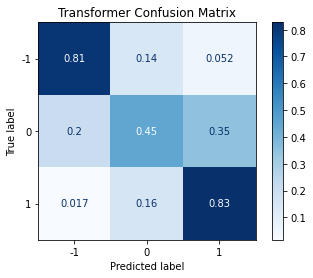

In [807]:
disp = ConfusionMatrixDisplay.from_predictions(
    testing_df[y_col],
    hugging_pred_df["pred_round"],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("Transformer Confusion Matrix")
transformer_f1 = f1_score(testing_df[y_col],hugging_pred_df["pred_round"],average="weighted")
transformer_mcc = matthews_corrcoef(testing_df[y_col],hugging_pred_df["pred_round"])
print(f"Transformer F1 Weighted Score: {transformer_f1}")
print(f"Transformer MCC: {transformer_mcc}")
print("Transformer Confusion Matrix")
print(disp.confusion_matrix)

Transformer - Custom Rounding - F1 Weighted Score: 0.7977947790083718
Transformer Confusion Matrix - Custom Rounding
[[0.86198515 0.0427639  0.09525096]
 [0.35957159 0.13668504 0.50374337]
 [0.03567602 0.04967231 0.91465167]]


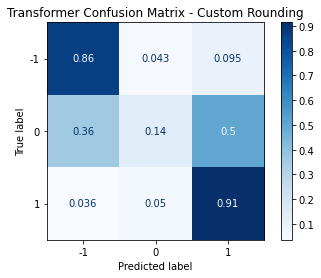

In [808]:
disp = ConfusionMatrixDisplay.from_predictions(
    testing_df[y_col],
    hugging_pred_df["pred_round_custom"],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("Transformer Confusion Matrix - Custom Rounding")
transformer_f1_custom = f1_score(testing_df[y_col],hugging_pred_df["pred_round_custom"],average="weighted")
transformer_mcc = matthews_corrcoef(testing_df[y_col],hugging_pred_df["pred_round_custom"])
print(f"Transformer - Custom Rounding - F1 Weighted Score: {transformer_f1_custom}")
print(f"Transformer - Custom Rounding - MCC: {transformer_mcc}")
print("Transformer Confusion Matrix - Custom Rounding")
print(disp.confusion_matrix)